# Geologic Project
---
Lithofacies Identification from wireline log data \
Nathaniel Horsfall \
4599680

---

In [1]:
# Import important packages
import pandas as pd
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from operator import itemgetter

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import seaborn as sns

In [2]:
# Import csv file and convert to dataFrame
rawdata = pd.read_csv('../input/fullcurves/FULLCURVES2.csv')

> Next cell contains util functions

In [3]:
# Count Function
# Pass list, dict and column key to count by, it returns a list with number of rows for each list item in the dict.
def getCount(listArg, dictArg, reqKey):
    countList = []
    for val in listArg:
        count = dictArg[dictArg[reqKey] == val].shape[0]
        countList.append(count)
    return countList


    
# Plot Logs function
def plotLogs(wellName, logs, logList,faciesColor, yKey, clusterList, clusterLabel, figSize=[15,12]):
    logs = logs.sort_values(by = yKey)
    faciesColMap = colors.ListedColormap(faciesColor[0:len(faciesColor)], 'indexed')
    yTop = logs[yKey].min()
    yBot = logs[yKey].max()
    nRows = 1
    nCols = len(logList) + len(clusterList)

    
    # make Plot base
    fig, cols = plt.subplots(nrows=nRows, ncols=nCols, figsize=figSize)
    fig.suptitle(f'Logs for Well {wellName}', fontsize=16, y=0.95)
    
    # Plot Log columns
    for idx,log in enumerate(logList):
        name = log['name']
        unit = log['unit']
        color = log['color']
        
        cols[idx].plot(logs[name], logs[yKey], color)
        cols[idx].set_xlabel(f'{name}[{unit}]', color=color)
        cols[idx].xaxis.set_label_position('top') 
        cols[idx].xaxis.tick_top()
        cols[idx].tick_params(axis='x', colors=color)
        cols[idx].set_ylim(yTop, yBot)
        cols[idx].invert_yaxis()
        cols[idx].grid()
        cols[idx].locator_params(axis='x', nbins=4)
        
        if idx != 0:
            cols[idx].set_yticklabels([])
    
    # Make colormap base
    separator = make_axes_locatable(cols[nCols-1])
    cax = separator.append_axes("right", size="20%", pad=0.1)

    
    
    # Formating colormap labels
    boundArr = []
    ticks = []
    faciesLen = len(faciesColor)
    for i in range(len(faciesColor)+1):
        boundArr.append(i)
        ticks.append(i+0.5)
        
    def tickFormatter(x,pos):
        xVal = int(x)
        if xVal < 0:
            return ''
        return faciesLabel[xVal]
    
    # Make cluster images
    for idx,cluster in enumerate(clusterList):
        clusterKey = cluster['key']
        clusterName = cluster['name']
        realIdx = idx + len(logList)
        clusterInstc =  np.repeat(np.expand_dims(logs[clusterKey].values, 1), 10,1)
        norm = colors.BoundaryNorm(boundaries=np.array(boundArr), ncolors=faciesLen+1)
        clImg = cols[realIdx].imshow(clusterInstc, interpolation='none', aspect='auto', cmap=faciesColMap, norm=norm)
        cols[realIdx].set_yticklabels([])
        cols[realIdx].set_xticks([])
        cols[realIdx].set_xlabel(f'{clusterName}')
        cols[realIdx].xaxis.set_label_position('top') 
        
        # Add colorbar to last cluster image 
        if realIdx == nCols - 1:
            fmt = mpl.ticker.FuncFormatter(tickFormatter)
            cbar = plt.colorbar(clImg,format=fmt,cax=cax, ticks=ticks)
    return fig


# Make confusion plot

def makeConfusionPlot(classifier, figsize=[5,5]):
    plt.figure(figsize=fisize)
    sns.heatmap(classifier,)


### Data Processing

In [4]:
# Sort rows by FaciesIndex
data = pd.DataFrame(rawdata).sort_values(by=['FaciesIndex'])

# Remove NaN values
data.dropna(inplace=True)

# Ensure FaciesIndex is of type Integer
data['FaciesIndex'] = data['FaciesIndex'].astype(int)

# Preview dataFrame
print(data.head())

        WellName  DEPTH (M)   GR (API)  NPHI (frac)  RHOB (g/cm)   RT (ohm.m)  \
0      15_9_F_12     3126.5  26.674333     0.218000     2.224167  2328.343333   
1751  15_9_19_SR     4337.5  31.223000     0.167213     2.242803    32.393333   
1750  15_9_19_SR     4337.0  34.305000     0.235328     2.202863    30.967500   
1749  15_9_19_SR     4336.5  38.313000     0.251257     2.189277    28.053333   
1748  15_9_19_SR     4336.0  37.930000     0.252590     2.209857    23.776667   

                 Facies  FaciesIndex  AC (US/F)  PE (BARN)  
0     F-UPPER SHOREFACE            0  85.878000   2.673300  
1751  F-UPPER SHOREFACE            0  88.683333   2.804267  
1750  F-UPPER SHOREFACE            0  86.165000   2.751000  
1749  F-UPPER SHOREFACE            0  86.393333   2.815600  
1748  F-UPPER SHOREFACE            0  80.490000   2.592600  


In [5]:
# Remove units from column names to make handling easier
data.rename(columns={'DEPTH (M)':'DEPTH', 
                    "GR (API)":"GR", 
                    "NPHI (frac)":"NPHI", 
                    "RHOB (g/cm)":"RHOB", 
                    "RT (ohm.m)":"RT",
                    "AC (US/F)":"DT",
                    "PE (BARN)":"PE"}, inplace = True)

# Define columns to be used as categories
data['WellName'] = data['WellName'].astype('category')
data['Facies'] = data['Facies'].astype('category')

# Get list of wells
wellList = data['WellName'].unique()
print('\n'.join(map(str,wellList))) 

15_9_F_12
15_9_19_SR
15_9_19_BT2
15_9_19_A
15_9_F_15_A
15_9_F_5
15_9_F_15
15_9_F_15_C
15_9_F_14
15_9_F_4
15_9_F_15_B


In [6]:
# Create column for facies colors
# faciesColors = ['#e84a5f', '#ff847c', '#feceab', '#00bcd4', '#fca652', '#0f3057', '#008891', '#ffefa0', '#9d65c9']
# faciesColors = ['#0278ae', '#056674', '#fe7171', '#ff9a76', '#eff48e', '#64958f', '#81b214', '#f5f1da', '#9d65c9']
faciesColors = ['#5a8258', '#3e6a9f', '#58aa82', '#918a7d', '#c36474', '#c6afd5', '#e9e889', '#87c671', '#c6b371']
#5a8258
#3e6a9f
#58aa82
#918a7d
#c36474
#c6afd5
#e9e889
#87c671
#c6b371
#c6b371
data['FaciesColor'] = data['FaciesIndex'].apply(lambda x: faciesColors[x-1])

# Make a sorted list of facies indexes
oldFaciesIndexList = data['FaciesIndex'].unique().tolist()
faciesIndexList = sorted(oldFaciesIndexList)

# Create list of facies labels
faciesLabel = ["USF","LSF","TB","OS","TC","MB","MSH","TFM","TFS"]

> Expand the next cell to see the list of facies and their corresponding labels

__Facies and their corresponding labels__

|Facies|Facies Label |
|-|-|
  |F-TIDAL BAR| TB|
  |F-UPPER SHOREFACE| USF|
  |F-OFFSHORE| OS|
  |F-TIDAL CHANNEL| TC|
  |F-MOUTHBAR| MB|
  |F-LOWER SHOREFACE| LSF|
  |F-MARSH| MSH|
  |F-TIDAL FLAT MUDDY| TFM|
  |F-TIDAL FLAT SANDY| TFS|
  

### Data Exploration

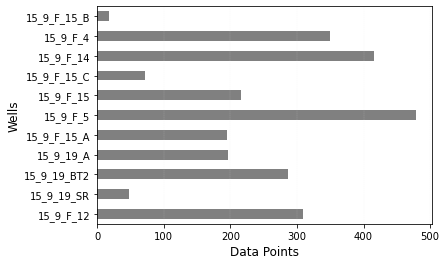

In [7]:
# Visualize number of data points per well
y_1 = wellList
x_1 = getCount(wellList, data, 'WellName') # getCount function is defined in the utils cell above.
  
dPoints = pd.DataFrame({'Wells':y_1, 'Data Points':x_1})
dPointsPlt = dPoints.plot.barh(y='Data Points', x='Wells', color='.5')
dPointsPlt.get_legend().remove()
dPointsPlt.set_xlabel('Data Points', fontsize='large')
dPointsPlt.set_ylabel('Wells', fontsize='large')
dPointsPlt.grid('on', which='major', axis='x',linestyle='dotted', linewidth=0.25,color='.9')

fig = dPointsPlt.get_figure()

# Use matplotlib to save in high resolution
plt.savefig('./wellsVsDataPoints.eps',format='eps', bbox_inches='tight')

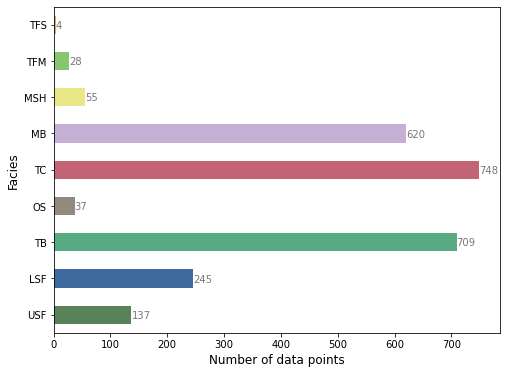

In [8]:
# Visualize number of data points per facies class
y_2 = faciesLabel
x_2 = getCount(faciesIndexList, data, 'FaciesIndex') # getCount function is defined in the utils cell above.
    
fPoints = pd.DataFrame({'Facies':y_2, 'Data Points':x_2})
fPointsImg = fPoints.plot.barh(y='Data Points', x='Facies',figsize=[8,6], color=faciesColors, legend=None)
fPointsImg.set_xlabel("Number of data points", fontsize='large');
fPointsImg.set_ylabel("Facies", fontsize='large');

# Attach labels to end of each bar
for i in fPointsImg.patches:
    # get_width pulls left or right; get_y pushes up or down
    fPointsImg.text(i.get_width()+.1, i.get_y()+.15, \
            str(round((i.get_width()), 2)), color='#777')


fig = fPointsImg.get_figure()
# Use matplotlib to save in high resolution
plt.savefig('./faciesVsCount.eps',format='eps', bbox_inches='tight')

In [9]:
# Visualize dataframe head 
dh = data.head(3)
dt = data.tail(2)
dTab = pd.concat([dh,dt])


print(dTab.to_latex(index=False)) 

\begin{tabular}{lrrrrrlrrrl}
\toprule
   WellName &   DEPTH &         GR &      NPHI &      RHOB &           RT &              Facies &  FaciesIndex &         DT &        PE & FaciesColor \\
\midrule
  15\_9\_F\_12 &  3126.5 &  26.674333 &  0.218000 &  2.224167 &  2328.343333 &   F-UPPER SHOREFACE &            0 &  85.878000 &  2.673300 &     \#c6b371 \\
 15\_9\_19\_SR &  4337.5 &  31.223000 &  0.167213 &  2.242803 &    32.393333 &   F-UPPER SHOREFACE &            0 &  88.683333 &  2.804267 &     \#c6b371 \\
 15\_9\_19\_SR &  4337.0 &  34.305000 &  0.235328 &  2.202863 &    30.967500 &   F-UPPER SHOREFACE &            0 &  86.165000 &  2.751000 &     \#c6b371 \\
  15\_9\_F\_15 &  3980.0 &  28.370000 &  0.160653 &  2.567200 &     1.313333 &  F-TIDAL FLAT SANDY &            8 &  67.561333 &  4.816767 &     \#87c671 \\
  15\_9\_F\_15 &  3979.5 &  33.230000 &  0.196820 &  2.523867 &     1.026667 &  F-TIDAL FLAT SANDY &            8 &  71.151667 &  5.054867 &     \#87c671 \\
\bottomrule
\en

In [10]:
## Prepare parameters for log plot function

# Make list of log curves to plot
logList = [
    {
        'name': 'GR',
        'unit': 'api',
        'color': 'green'
    },
    {
        'name': 'NPHI',
        'unit': 'frac',
        'color': 'blue'
    },
    {
        'name': 'RHOB',
        'unit': 'g/cm\^3',
        'color': 'red'
    },
    {
        'name': 'RT',
        'unit': 'ohm.m',
        'color': 'black'
    },
    {
        'name':'PE',
        'unit': 'barn',
        'color': 'purple'
    }
]

# Indicate key for cluster map values
genClusterList = [
    {
        'key': 'FaciesIndex',
        'name': 'Facies'
    }
]

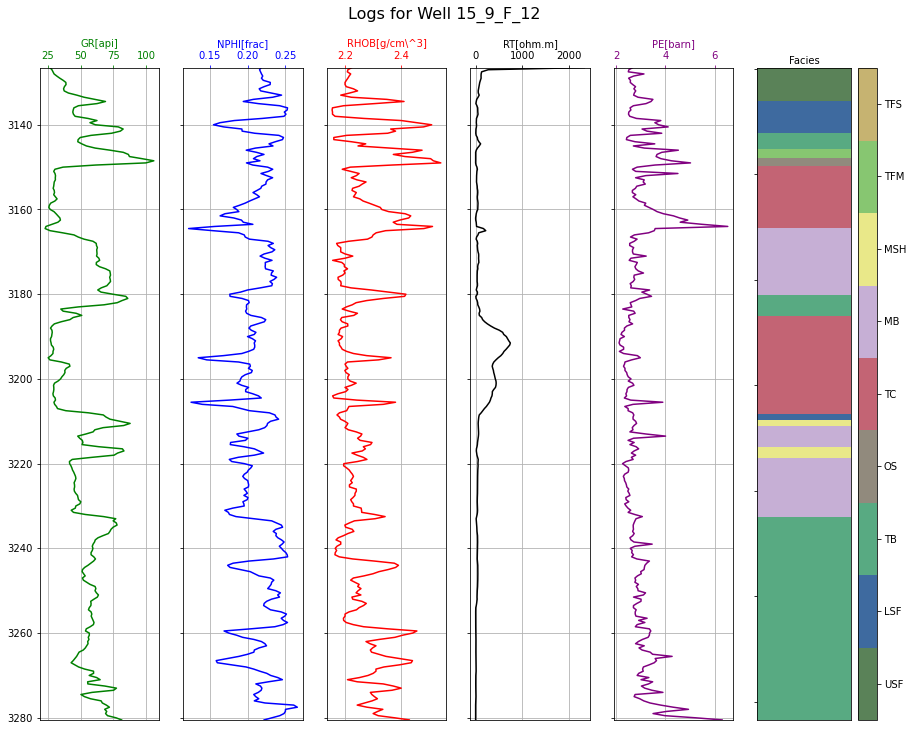

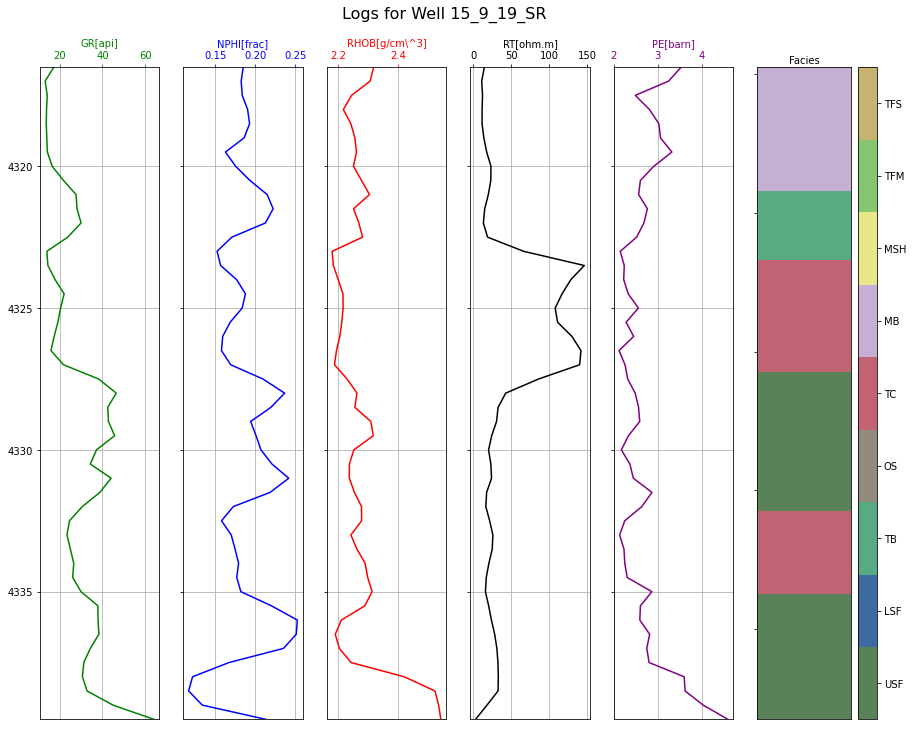

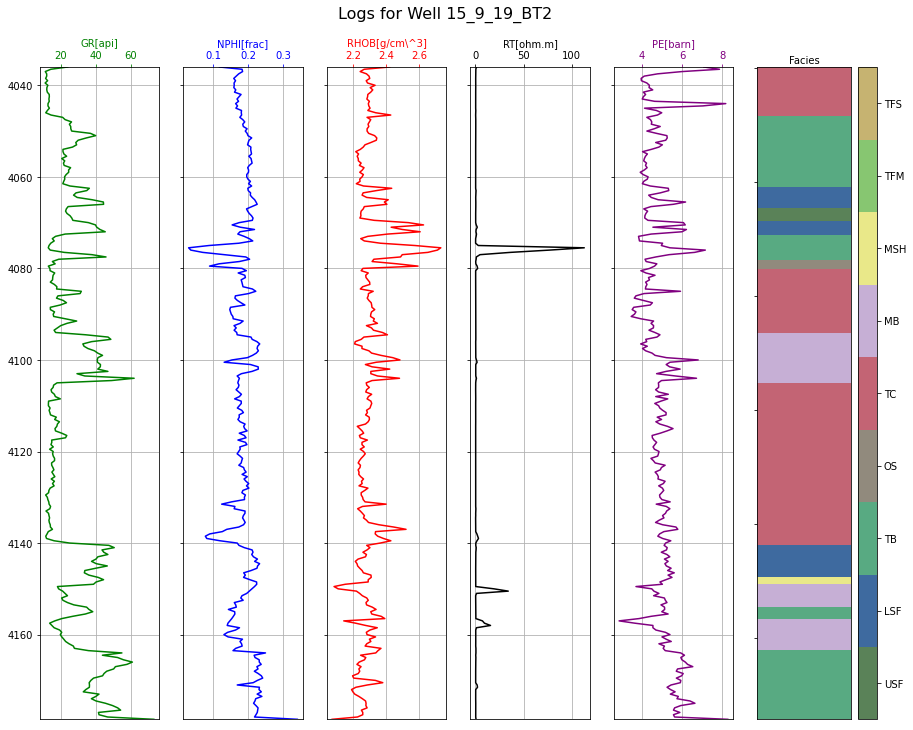

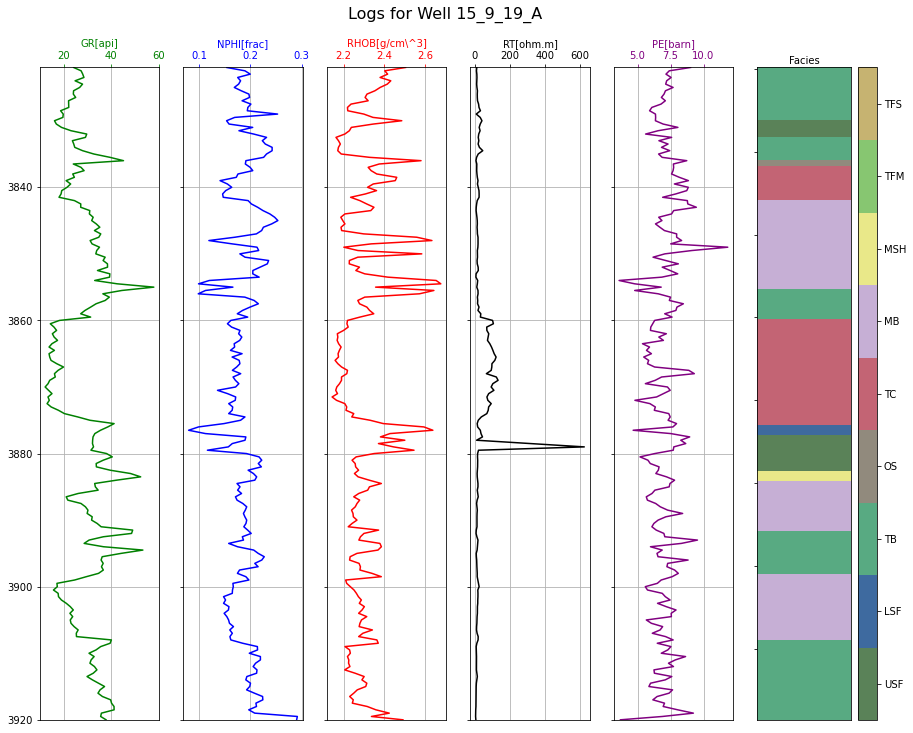

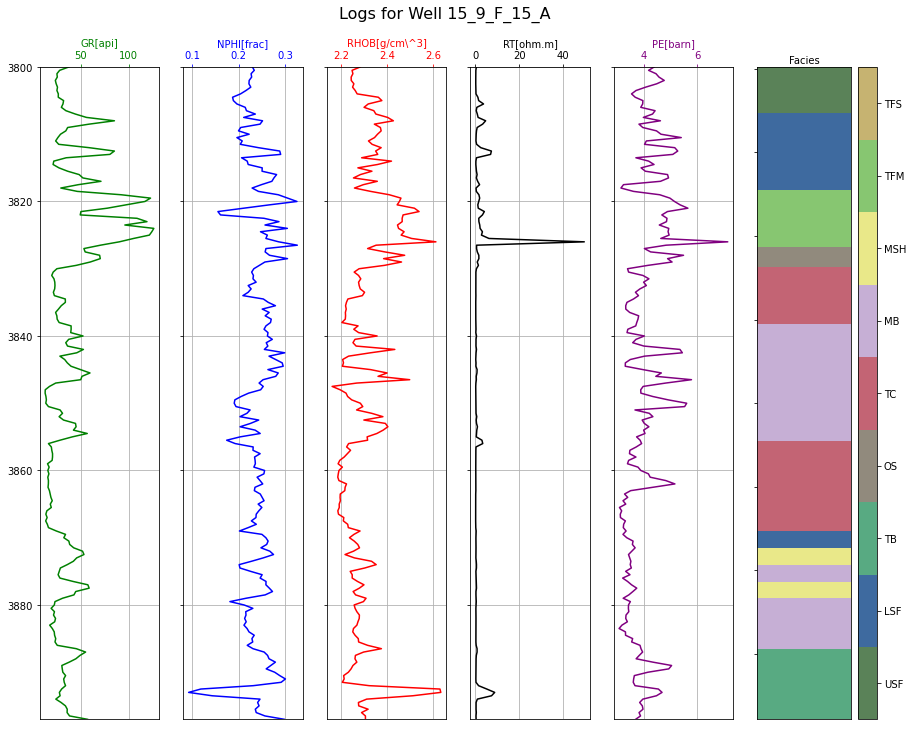

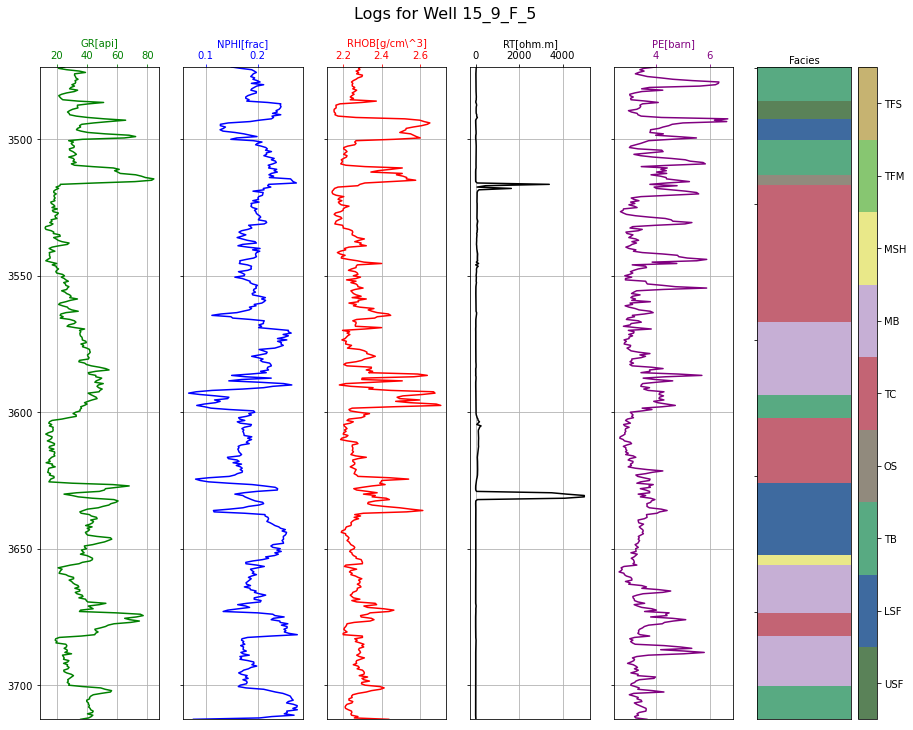

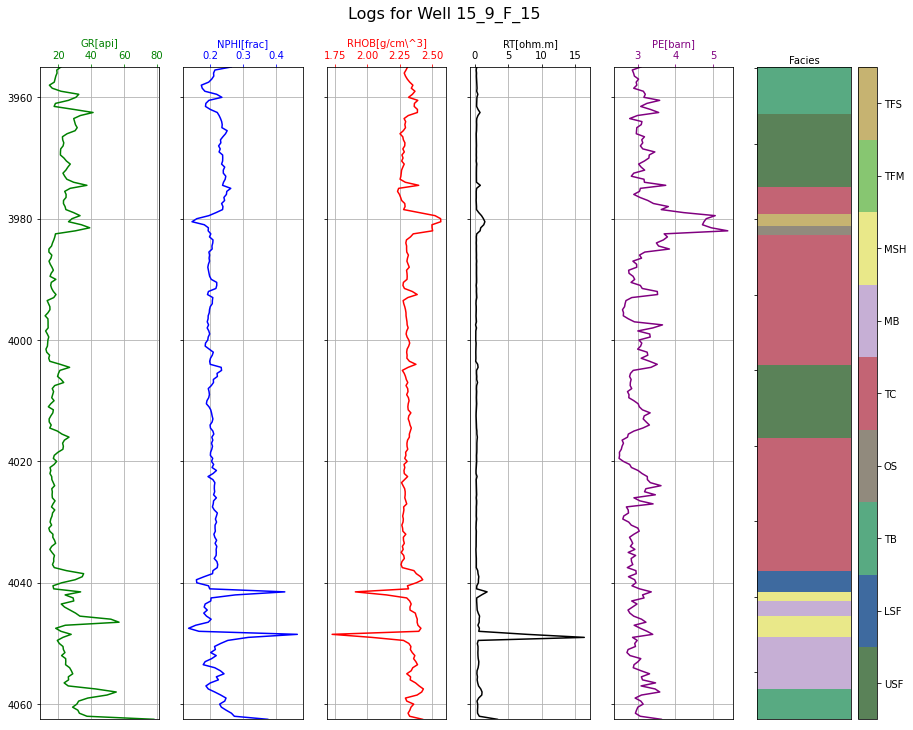

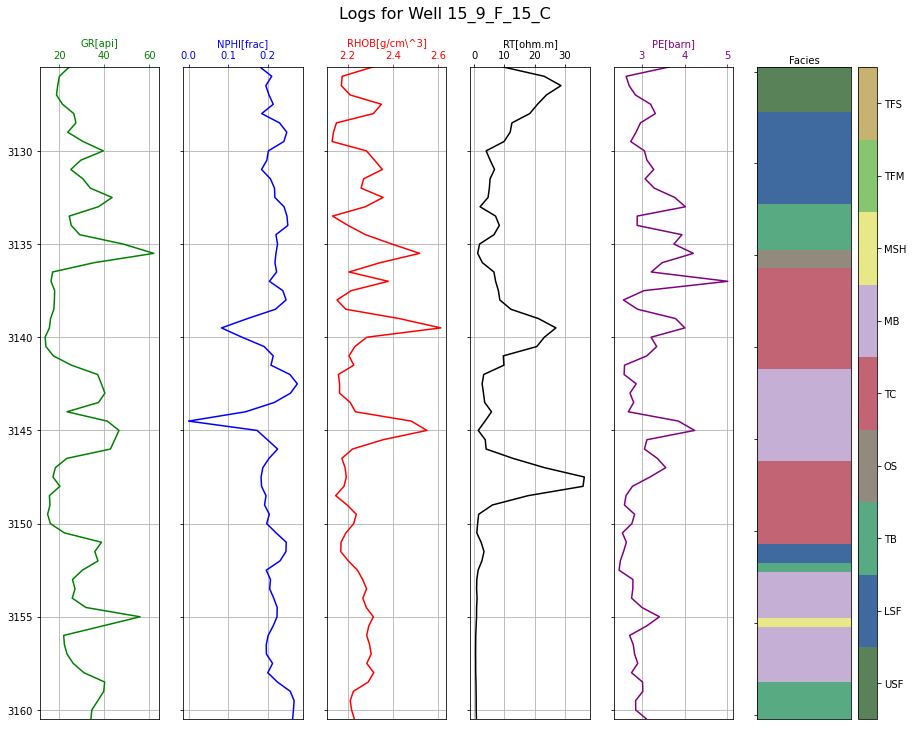

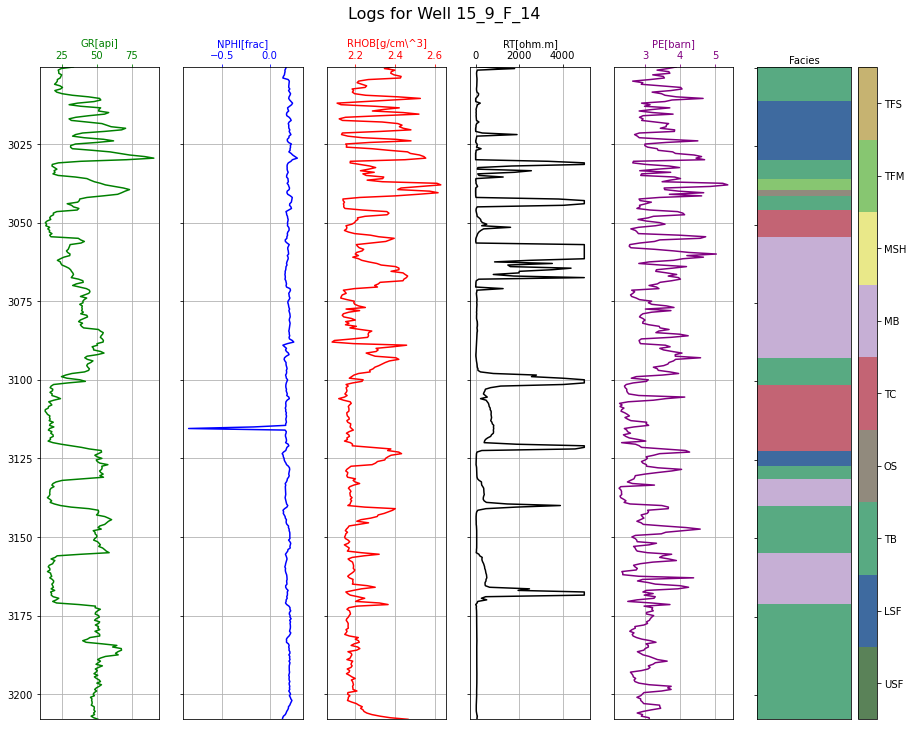

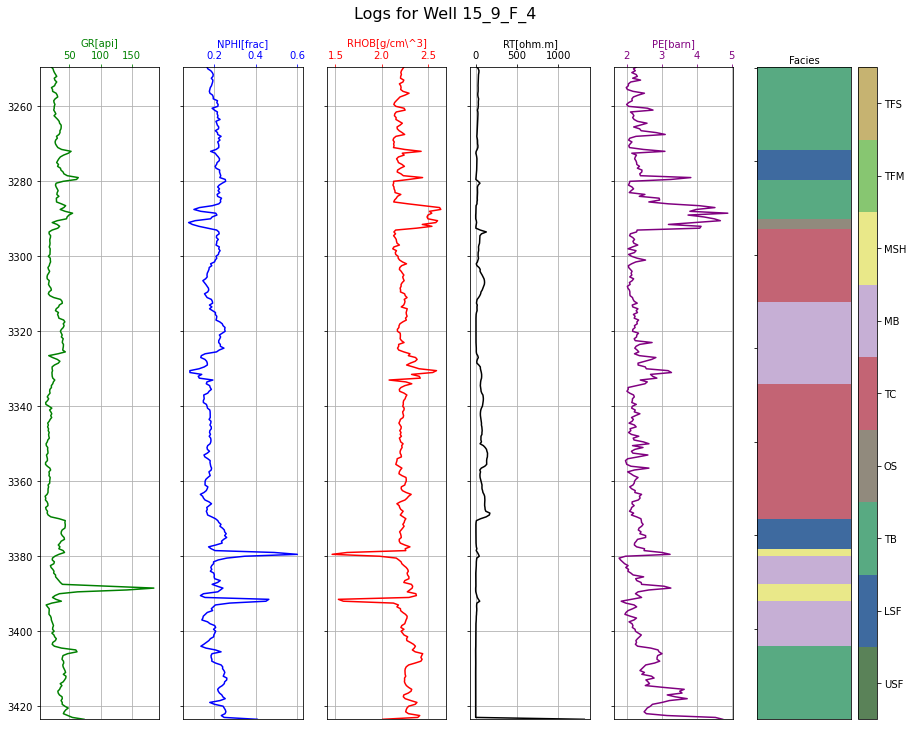

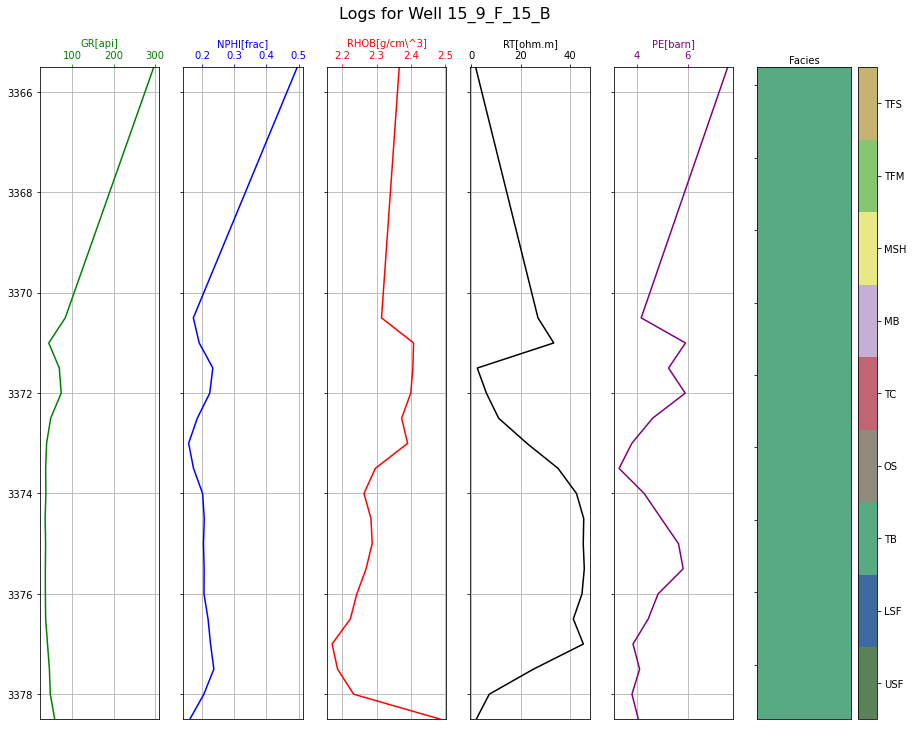

In [11]:
# Plot log curves for wells

# Plot well 15_9_F_4 aka blind well
# plotLogs('15_9_F_4',data[data['WellName'] == '15_9_F_4'], logList,faciesColors,'DEPTH',genClusterList, faciesLabel)

## Uncomment next two lines to plot all wells
for well in wellList:
    wellFig = plotLogs(well, data[data['WellName'] == well], logList,faciesColors,'DEPTH',genClusterList, faciesLabel)
    wellFig.savefig(f'./{well}_plot.eps',format='eps', bbox_inches='tight')

### Train and Test SVM Model

In [12]:
# Extract blind well data
blindWell = data[data['WellName'] == '15_9_F_4'].copy(deep=False)
newData = data[data['WellName'] != '15_9_F_4'].copy(deep=False)

# Select feature vectors
featureVectors = newData.drop(['WellName',"DEPTH",'Facies','FaciesIndex','FaciesColor'], axis=1)
blindFeatureVectors = blindWell.drop(['WellName',"DEPTH",'Facies','FaciesIndex','FaciesColor'], axis=1)

print(featureVectors)
print(blindFeatureVectors)

              GR      NPHI      RHOB           RT         DT        PE
0      26.674333  0.218000  2.224167  2328.343333  85.878000  2.673300
1751   31.223000  0.167213  2.242803    32.393333  88.683333  2.804267
1750   34.305000  0.235328  2.202863    30.967500  86.165000  2.751000
1749   38.313000  0.251257  2.189277    28.053333  86.393333  2.815600
1748   37.930000  0.252590  2.209857    23.776667  80.490000  2.592600
...          ...       ...       ...          ...        ...       ...
1564  121.871667  0.261533  2.459900     2.833333   0.000000  4.940667
1261   34.055000  0.183178  2.500350     1.362500  76.901750  4.716300
1260   26.256667  0.146200  2.568600     1.530000  69.716000  4.756233
1259   28.370000  0.160653  2.567200     1.313333  67.561333  4.816767
1258   33.230000  0.196820  2.523867     1.026667  71.151667  5.054867

[2234 rows x 6 columns]
             GR      NPHI      RHOB         RT          DT        PE
1801  52.693750  0.181500  2.427250   7.545000   77.28

In [13]:
# Standardizing training data [Whitening Process]
scaler = preprocessing.StandardScaler().fit(featureVectors)
scaledFeatures = scaler.transform(featureVectors)
faciesList = newData['FaciesIndex'].values  

In [14]:
# Split data randomly into train and test groups
randomState = 30
testSize = 0.2
X_train, X_test, Y_train, Y_test = train_test_split(scaledFeatures,faciesList, test_size=testSize, random_state=randomState)

In [15]:
def classAndPredict(svcParams, X_train,Y_train, X_test,Y_test, test=False):
    # destructure parameters
    C,gamma,kernel,degree = itemgetter('C','gamma','kernel','degree')(svcParams)
    
    classifier = svm.SVC(C=C,gamma=gamma,kernel=kernel,degree=degree)
    classifier.fit(X_train,Y_train)
    if test == True:
        predictions = classifier.predict(X_test)
        accuracy = accuracy_score(Y_test, predictions)
        return [accuracy,predictions]
    return classifier

In [16]:
def getOptimalParams(gammaRange, CRange,X_train,Y_train, X_test):
    plotData = [[],[],[]]
    highest = [0,0,0]
    for idx, val in enumerate(gammaRange):
        tempPlot = []
        for x in np.arange(CRange[0],CRange[1],CRange[2]):
            svcParams = {
                        'C':x,
                        'gamma':gammaRange[idx],
                        'kernel':'rbf',
                        'degree':2
                    }
            accVal = classAndPredict(svcParams,X_train,Y_train, X_test, Y_test)[0]
            if accVal > highest[0]:
                highest[0] = accVal; highest[1] = x; highest[2] = gammaRange[idx]
            plotData[0].append(float("{:.3f}".format(accVal)))
            plotData[1].append(round(x))
            plotData[2].append(gammaRange[idx])
    t = pd.DataFrame(plotData)
    t = t.transpose()
    t.columns=['Accuracy','C','Gamma']
    return {'table': t, 'highest':highest}

### Getting Optimal Parameters 

Uncomment lines of code in the next two cells to try for optimal gamma and C parameters. It takes a while depending on how much interval you choose.

In [17]:
# optimalData = getOptimalParams(np.array([0.0001, 0.001, 0.01, 0.1, 1, 10]),np.array([0.01,100,1]),X_train,Y_train, X_test,scaledFeatures)
# optimalTable = optimalData['table']
# optimalValues = optimalData['highest']

# print(f'Optimal parameters are => C:{optimalValues[1]}, gamma:{optimalValues[2]} with an accuracy of {optimalValues[0]}')

In [18]:
# ord = optimalTable['C'].to_numpy()
# yord = optimalTable['Accuracy'].value_counts().index

# figs = sns.FacetGrid(optimalTable, col='Gamma',col_wrap=1, ylim=(0,1), aspect=5)
# figs.map(sns.pointplot,'C','Accuracy',color=".3")


In [19]:
def plotConfMatrix(cm,target_names,title='Confusion matrix', cmap=None,normalize=True):
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('Actual facies')
    plt.xlabel('Predicted facies\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    return plt

In [20]:
# Test data
svcParams = {
            'C':6.00099,
            'gamma':1,
            'kernel':'rbf',
            'degree':2
        }
classifier = classAndPredict(svcParams,X_train,Y_train,X_test, Y_test)
predictionz = classifier.predict(scaledFeatures)
dataConf = confusion_matrix(faciesList, predictionz)

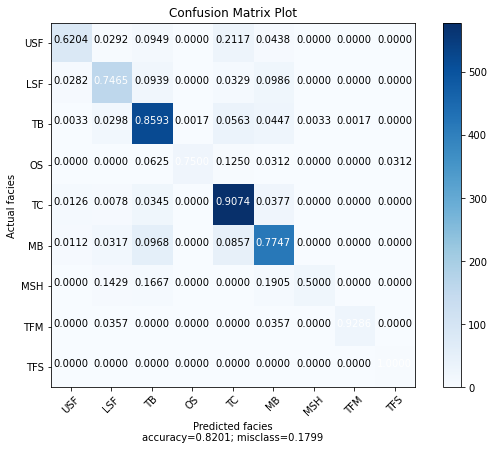

In [21]:
confPlot = plotConfMatrix(dataConf,normalize=True,title='Confusion Matrix Plot',target_names=faciesLabel)
confPlot.savefig('./confPlot.eps',format='eps', bbox_inches='tight')

In [22]:
# Test blind well

# Standardizing blind data with the same process as the training data
blindScaler = preprocessing.StandardScaler().fit(blindFeatureVectors)
blindScaledFeatures = scaler.transform(blindFeatureVectors)
blindFaciesList = blindWell['FaciesIndex'].values  

blindPredictionz = classifier.predict(blindScaledFeatures)
blindDataConf = confusion_matrix(np.array(blindFaciesList), blindPredictionz)
blindWell['Prediction'] = blindPredictionz

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


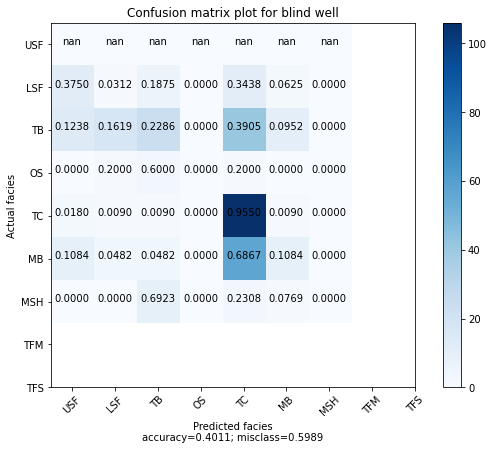

In [23]:
blindConfPlot = plotConfMatrix(blindDataConf,normalize=True,title='Confusion matrix plot for blind well',target_names=faciesLabel)
blindConfPlot.savefig('./blindConfPlot.eps',format='eps', bbox_inches='tight')

In [24]:
blindFaciesLabel = ['LSF', 'TB', 'OS', 'TC', 'MB', 'MSH']

blindReport = classification_report(blindFaciesList, blindPredictionz)
print(blindReport)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.04      0.03      0.04        32
           2       0.51      0.23      0.32       105
           3       0.00      0.00      0.00         5
           4       0.48      0.95      0.64       111
           5       0.39      0.11      0.17        83
           6       0.00      0.00      0.00        13

    accuracy                           0.40       349
   macro avg       0.20      0.19      0.17       349
weighted avg       0.40      0.40      0.34       349



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


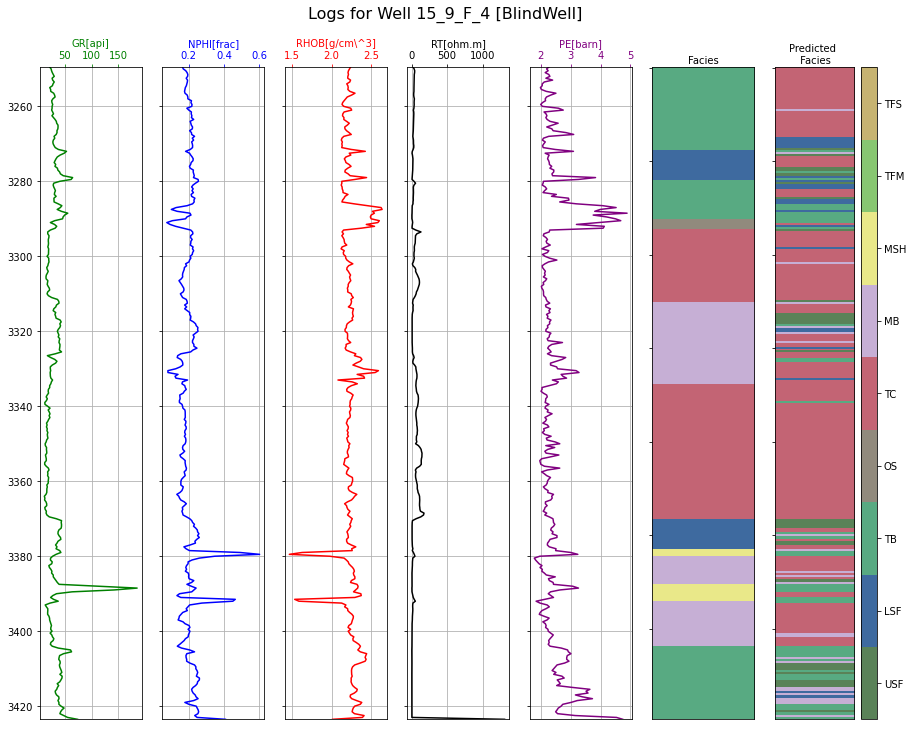

In [25]:
# Plot logs with predicted values
blindClusterList = [
    {
        'key': 'FaciesIndex',
        'name': 'Facies'
    },    
    {
        'key': 'Prediction',
        'name': 'Predicted \n Facies'
    }
]
blFig = plotLogs('15_9_F_4 [BlindWell]',blindWell, logList,faciesColors,'DEPTH',blindClusterList, faciesLabel)
blFig.savefig('./faciesComparison.eps',format='eps', bbox_inches='tight')